# Text Embedding
In this notebook, we generate 10-K filings text embeddings with the Vertex AI [`textembedding-gecko`](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-embeddings) model.  Unstructured text from 10K filings has been extracted using a parser beforehand.

In this notebook, we will:
1. Get 10-K filings unstructured text from a Google storage bucket
2. specifically select Item 1 from the 10K which describes the business of the company: who and what the company does, what subsidiaries it owns, and what markets it operates in. 
3. Chunk the text into natural sections using NLTK (to avoid input token limits)
4. Save text with embeddings to csv to stage for loading into graph

In [ ]:
%%capture
%pip install --user tabulate sentence-transformers
%pip install --user altair

## Get 10-K Filings from Google Cloud

In [1]:
from google.cloud import storage

storage_client = storage.Client()
(storage_client
 .bucket('neo4j-datasets')
 .blob('form10k/form10k-clean.zip')
 .download_to_filename('form10k-clean.zip'))

In [2]:
!unzip -qq -n 'form10k-clean.zip'

## 10-K Filings Exploration and Chunking
Let's open one file to understand its contents.  It is actually a json file. 

In [3]:
import json
with open('./form10k-clean/0001830197-22-000038.txt') as f:
    f10_k = json.load(f)

We are interested in Item 1 specifically. 

Item 1 describes the business of the company: who and what the company does, what subsidiaries it owns, and what markets it operates in. It may also include recent events, competition, regulations, and labor issues. (Some industries are heavily regulated, and have complex labor requirements, which have significant effects on the business.) Other topics in this section may include special operating costs, seasonal factors, or insurance matters.

In [4]:
len(f10_k['item1'])

241333

This text has the ability to exceed token limits for `textembedding-gecko`.  Also the quality of embeddings can go down if the text gets to large. As such we should find some way to chunk the text up into seperate sections for embedding.

Below is a way to do this with NLTK. 

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text = f10_k['item1']

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,
    chunk_overlap  = 15,
    length_function = len,
    is_separator_regex = False,
)
docs = text_splitter.split_text(text)

In [6]:
print(docs[0])

>Item 1. Business 
Company Overview
We are a leading residential mortgage originator and servicer driven by a mission to create financially healthy, happy homeowners. We do this by delivering scale, efficiency and savings to our partners and customers. Our business model is focused on leveraging a nationwide network of partner relationships to drive sustainable origination growth. We support our origination operations through a robust operational infrastructure and a highly responsive customer experience. We then leverage our servicing platform to manage the customer experience. We believe that the complementary relationship between our origination and servicing businesses allows us to provide a best-in-class experience to our customers throughout their homeownership lifecycle.
Our primary focus is our Wholesale channel, which is a business-to-business-to-customer distribution model in which we utilize our relationships with independent mortgage brokerages, which we refer to as our Bro

## Getting 10-K Text Embeddings with VertexAI
Now that we understand our data and how to chunk it.  Let's Generate embeddings.

In [7]:
# Note, you will need to set your project_id
project_id = 'neo4jbusinessdev'
location = 'us-central1'

In [8]:
# Instantiate the text ebmedding model
from vertexai.language_models import TextEmbeddingModel
EMBEDDING_MODEL = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

In [9]:
# We will need a chunking utility to make things easier as we loop through files
def chunks(xs, n=5):
    n = max(1, n)
    return [xs[i:i + n] for i in range(0, len(xs), n)]

In [10]:
# Function for splitting and calculating embeddings
def create_text_embedding_entries(input_text:str, company_name: str, cusip: str):
    # text_splitter = NLTKTextSplitter(chunk_size = 8000)
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 2000,
        chunk_overlap  = 15,
        length_function = len,
        is_separator_regex = False,
    )
    docs = text_splitter.split_text(input_text)
    res = []
    seq_id = -1
    for d in chunks(docs):
        embeddings = EMBEDDING_MODEL.get_embeddings(d)
        for i in range(len(d)):
            seq_id += 1
            res.append({'companyName': company_name, 'cusip': cusip, 'seqId': seq_id, 'contextId': company_name + str(seq_id), 'textEmbedding': embeddings[i].values, 'text': d[i]})
    return res

In [11]:
# Get file names
import os
file_names = os.listdir('./form10k-clean/')
len(file_names)

95

In [15]:
# Primary loop.  This could take 30 minutes to an hour.
count = 0
embedding_entries = []
for file_name in file_names:
    if '.txt' in file_name:
        count+=1
        if count%10 == 0:
            print(f'Parsed {count} of {len(file_names)}')
        with open('./form10k-clean/' + file_name) as f:
            f10_k = json.load(f)
        embedding_entries.extend(create_text_embedding_entries(f10_k['item1'], f10_k['companyName'], f10_k['cusip']))
len(embedding_entries)

Parsed 10 of 95
Parsed 20 of 95
Parsed 30 of 95
Parsed 40 of 95
Parsed 50 of 95
Parsed 60 of 95
Parsed 70 of 95
Parsed 80 of 95
Parsed 90 of 95


3652

## Save 10-K Documents with Embeddings
We will save these locally to use in graph loading, in the next part.

In [16]:
import pandas as pd
edf = pd.DataFrame(embedding_entries)

In [17]:
edf

,companyName,cusip,seqId,contextId,textEmbedding,text
0,DOLLAR TREE STORES I,256677105,0,DOLLAR TREE STORES I0,"[0.0010533200111240149, -0.021037260070443153,...",>Item 1. Business\n” for further discussion of...
1,DOLLAR TREE STORES I,256677105,1,DOLLAR TREE STORES I1,"[0.006951881572604179, 0.0037470574025064707, ...",Plus\n;\n•\nthe introduction of selected Dolla...
2,DOLLAR TREE STORES I,256677105,2,DOLLAR TREE STORES I2,"[-0.046519629657268524, -0.009122439660131931,...",The rollout of our initiative to add price poi...
3,DOLLAR TREE STORES I,256677105,3,DOLLAR TREE STORES I3,"[-0.00760427862405777, -0.018772093579173088, ...","In fiscal 2019, we recorded a $313.0 million n..."
4,DOLLAR TREE STORES I,256677105,4,DOLLAR TREE STORES I4,"[-0.00876693706959486, -0.014356384053826332, ...",We rely extensively on our computer and techno...
...,...,...,...,...,...,...
3647,ARK RESTAURANTS CORP,00214Q104,11,ARK RESTAURANTS CORP11,"[-0.03415543586015701, -0.022621333599090576, ...",We have experienced aggressive competition for...
3648,ARK RESTAURANTS CORP,00214Q104,12,ARK RESTAURANTS CORP12,"[-0.04287169873714447, -0.028097117319703102, ...",9\nAlcoholic beverage control regulations requ...
3649,ARK RESTAURANTS CORP,00214Q104,13,ARK RESTAURANTS CORP13,"[-0.031908340752124786, -0.026195261627435684,...",We are subject to “dram-shop” statutes in most...
3650,ARK RESTAURANTS CORP,00214Q104,14,ARK RESTAURANTS CORP14,"[-0.026799874380230904, -0.029259834438562393,...","Our business is highly seasonal; however, our ..."


Provide your Neo4j credentials.  We need the DB conection URL, the username (probably `neo4j`), and your password.

In [ ]:
#database credentials
NEO4J_URI= "neo4j+s://xxxxx.databases.neo4j.io"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD= "password"

In [14]:
from graphdatascience import GraphDataScience

gds = GraphDataScience(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD),
    aura_ds=True
)
gds.set_database('neo4j')

Remember to create indexes. We will be merging 10K documents by `companyName`. In a production setting, we would want to use a better identifier here (like we did with cusip for Company) However, this should suffice for our intents and purposes as we are just getting acquainted to learning about semantic search.

In [101]:
gds.run_cypher('CREATE INDEX company_name IF NOT EXISTS FOR (n:Company) ON (n.companyName)')
gds.run_cypher('CREATE CONSTRAINT unique_document_id IF NOT EXISTS FOR (n:Document) REQUIRE (n.documentId) IS NODE KEY')

""


Due to the size of the documents we will want to transform the dataframe into a list of dict that we can chunk up and insert via parameterized query.

In [18]:
emb_entries = edf.to_dict(orient='records')

In [139]:
%%time

total = len(emb_entries)
count = 0
for d in chunks(emb_entries, 100):
    gds.run_cypher('''
    UNWIND $records AS record
    MATCH(c:Company {cusip:record.cusip})
    MERGE(b:Document {documentId:record.contextId})
    SET b.documentType='FORM_10K_ITEM1', b.seqId = record.seqId, b.textEmbedding = record.textEmbedding, b.text = record.text
    MERGE(c)-[:HAS]->(b)
    RETURN count(b) as cnt
    ''', params = {'records':d})
    count += len(d)
    print(f'loaded {count} of {total}')

Failed to write data to connection ResolvedIPv4Address(('34.142.144.246', 7687)) (ResolvedIPv4Address(('34.142.144.246', 7687)))
Failed to write data to connection IPv4Address(('243a037a.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.142.144.246', 7687)))


loaded 100 of 3652
loaded 200 of 3652
loaded 300 of 3652
loaded 400 of 3652
loaded 500 of 3652
loaded 600 of 3652
loaded 700 of 3652
loaded 800 of 3652
loaded 900 of 3652
loaded 1000 of 3652
loaded 1100 of 3652
loaded 1200 of 3652
loaded 1300 of 3652
loaded 1400 of 3652
loaded 1500 of 3652
loaded 1600 of 3652
loaded 1700 of 3652
loaded 1800 of 3652
loaded 1900 of 3652
loaded 2000 of 3652
loaded 2100 of 3652
loaded 2200 of 3652
loaded 2300 of 3652
loaded 2400 of 3652
loaded 2500 of 3652
loaded 2600 of 3652
loaded 2700 of 3652
loaded 2800 of 3652
loaded 2900 of 3652
loaded 3000 of 3652
loaded 3100 of 3652
loaded 3200 of 3652
loaded 3300 of 3652
loaded 3400 of 3652
loaded 3500 of 3652
loaded 3600 of 3652
loaded 3652 of 3652
CPU times: user 12.8 s, sys: 97.6 ms, total: 12.9 s
Wall time: 37.6 s


## Check Data

In [19]:
# Check node count
gds.run_cypher('MATCH(doc:Document) RETURN count(doc)')

,count(doc)
0,3536


Note that we were only getting 10-K docs for a minority of companies. It should be fine for this, but in a more rigorous setting, you may want to try and pull more.  There are likely a few factors attributing to this. 

1. We used company names to search EDGAR which resulted in many misses and dups which were discarded. In a more rigorous setting, we would investigate other endpoints and use more parsing to extract EDGAR cik keys for exact matching companies when pulling forms.

2. Company names are not consistent across form13 filings, so even if we successfully pull on one version of a company name, we may not be able to merge it into the graph via the one company name represented there. 

3. Not all companies in the dataset are obligated to file 10-Ks.

In [20]:
# Check count and percentage of companies with 10K docs.  Note it is the minority
gds.run_cypher('''
MATCH(b:Company)
WITH b, count{(b)-[:HAS]->(d:Document)} AS docCount
WITH count(b) AS total, sum(toInteger(docCount > 0)) AS numWithDocs
RETURN total, numWithDocs, round(100*toFloat(numWithDocs)/toFloat(total), 2) As PercWithDocs
''')

,total,numWithDocs,PercWithDocs
0,149,48,32.21


You might note that there are duplicate names.  For our purposes here, we will treat it as entity resolution, meaning that we treat companies with the same name as belonging to the same overarching entity for semantic search. In a more rigorous setting, we would need to disambiguate with other EDGAR keys.

In [21]:
# Show duplicates via HAS relationship
gds.run_cypher('''
MATCH(b:Company)
RETURN count(b) AS totalCompanies, count(DISTINCT b.companyName) AS uniqueCompanyNames
''')

,totalCompanies,uniqueCompanyNames
0,149,149


## View Embeddings as Clusters

In [22]:
import altair as alt

def generate_chart(df,xcol,ycol,lbl='on',color='basic',title='', tooltips=['documentId'], label=''):
  chart = alt.Chart(df).mark_circle(size=30).encode(
    x=
    alt.X(xcol,
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),

    y=
    alt.Y(ycol,
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),
    
    color= alt.value('#333293') if color == 'basic' else color,
    tooltip=tooltips
    )

  if lbl == 'on':
    text = chart.mark_text(align='left', baseline='middle',dx=7, size=5,color='black').encode(text=label, color= alt.value('black'))
  else:
    text = chart.mark_text(align='left', baseline='middle',dx=10).encode()

  result = (chart + text).configure(background="#FDF7F0"
        ).properties(
        width=800,
        height=500,
        title=title
       ).configure_legend(
  orient='bottom', titleFontSize=18,labelFontSize=18)
        
  return result

In [23]:
# Reduce dimensionality using PCA
from sklearn.decomposition import PCA

# Function to return the principal components
def get_pc(arr,n):
  pca = PCA(n_components=n)
  embeds_transform = pca.fit_transform(arr)
  return embeds_transform

In [24]:
emb_df = gds.run_cypher("MATCH (c:Company)-[:HAS]->(n:Document) RETURN c.companyName as companyName, n.documentId as documentId, n.text as text, n.textEmbedding as emb LIMIT 1000")
emb_df

,companyName,documentId,text,emb
0,Amazon Inc,AMAZON C2,We serve authors and independent publishers wi...,"[0.006696853321045637, -0.011619175784289837, ..."
1,Amazon Inc,AMAZON C1,Consumers\nWe serve consumers through our onli...,"[-0.0005904108402319252, -0.018458925187587738..."
2,Amazon Inc,AMAZON C3,Our businesses encompass a large variety of pr...,"[-0.0012867733603343368, -0.032372746616601944..."
3,Amazon Inc,AMAZON C8,"70\nCo-CEO, President, and Chair of IronNet Cy...","[0.00752410851418972, -0.05854441598057747, -0..."
4,Amazon Inc,AMAZON C0,>Item 1.\nBusiness\nThis Annual Report on Form...,"[0.023792171850800514, -0.02033819444477558, -..."
...,...,...,...,...
995,GLOBAL X CLOUD COMPUTING ETF,Global Partner Acquisition Corp Ii40,our initial business combination or to redeem ...,"[-0.007273248862475157, 0.017977459356188774, ..."
996,GLOBAL X CLOUD COMPUTING ETF,Global Partner Acquisition Corp Ii48,"However, we would not be restricting our share...","[0.01268983818590641, -0.021884022280573845, -..."
997,GLOBAL X CLOUD COMPUTING ETF,Global Partner Acquisition Corp Ii14,These criteria are not intended to be exhausti...,"[0.015977878123521805, -0.04065703600645065, 0..."
998,GLOBAL X CLOUD COMPUTING ETF,Global Partner Acquisition Corp Ii12,➤\n\n\n“Partnership” Sale: We may seek to a...,"[-0.01175097655504942, -0.02222239226102829, -..."


In [ ]:
# Reduce embeddings to 2 principal components to aid visualization
import numpy as np
from sklearn.cluster import KMeans

embeds = np.array(emb_df['emb'].tolist())
embeds_pc2 = get_pc(embeds,2)

df_clust =pd.concat([emb_df, pd.DataFrame(embeds_pc2)], axis=1)
n_clusters=5

# Cluster the embeddings
kmeans_model = KMeans(n_clusters=n_clusters, n_init=1, random_state=0)
classes = kmeans_model.fit_predict(embeds).tolist()
df_clust['cluster'] = (list(map(str,classes)))

# Plot on a chart
df_clust.columns = df_clust.columns.astype(str)
generate_chart(df_clust.iloc[:],'0','1',lbl='off',color='cluster',title='K-Means Clustering with n Clusters', tooltips=['documentId', 'text'], label='')


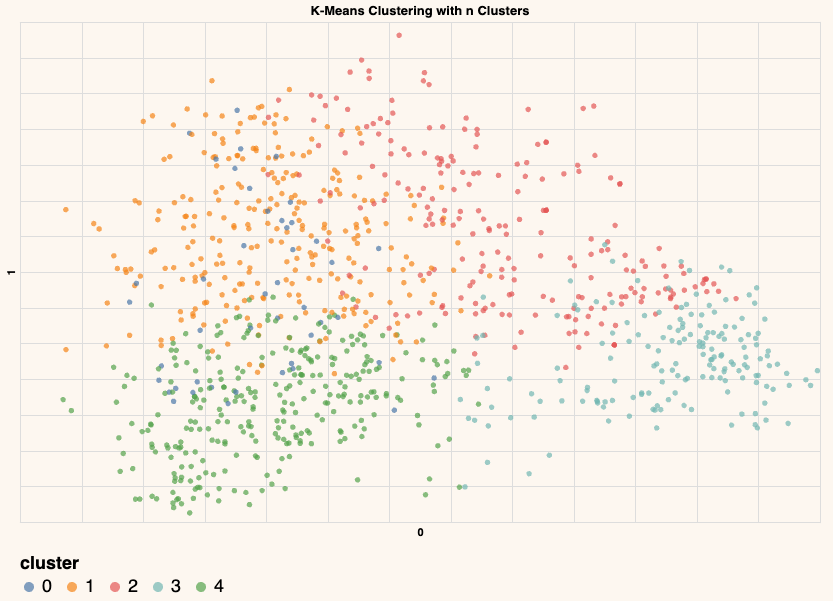